In [1]:
import h3
import geopandas as gpd
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Polygon

In [2]:
boundary = gpd.read_file("MasterPlan2019PlanningAreaBoundaryNoSea.geojson")
clinics = gpd.read_file("CHASClinics.geojson")
socialservices = gpd.read_file("SocialServiceAgencies.geojson")
supermarkets = gpd.read_file("SupermarketsGEOJSON.geojson")
eatingestablishments = gpd.read_file("EatingEstablishments.geojson")

In [5]:
supermarkets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         526 non-null    object  
 1   Description  526 non-null    object  
 2   geometry     526 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 12.5+ KB


In [7]:
eatingestablishments.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34378 entries, 0 to 34377
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Name           34378 non-null  object  
 1   description    34378 non-null  object  
 2   tessellate     34378 non-null  int32   
 3   extrude        34378 non-null  int32   
 4   visibility     34378 non-null  int32   
 5   LIC_NAME       34378 non-null  object  
 6   BLK_HOUSE      34310 non-null  object  
 7   STR_NAME       34364 non-null  object  
 8   UNIT_NO        23937 non-null  object  
 9   POSTCODE       34378 non-null  object  
 10  LIC_NO         34378 non-null  object  
 11  BUSINESS_NAME  31473 non-null  object  
 12  LEVEL_NO       23978 non-null  object  
 13  LIC_ISS_DATE   34378 non-null  object  
 14  LIC_EXP_DATE   34378 non-null  object  
 15  INC_CRC        34378 non-null  object  
 16  FMEL_UPD_D     34378 non-null  object  
 17  snippet        34378 no

In [9]:
eatingestablishments.head()

,Name,description,tessellate,extrude,visibility,LIC_NAME,BLK_HOUSE,STR_NAME,UNIT_NO,POSTCODE,LIC_NO,BUSINESS_NAME,LEVEL_NO,LIC_ISS_DATE,LIC_EXP_DATE,INC_CRC,FMEL_UPD_D,snippet,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,-1,0,-1,OMU PTE. LTD.,3,TEMASEK BOULEVARD,301A,38983,CE17J24A000,OMU,1,13/11/2018,12/11/2019,707D4008F5437A96,20190124164538,,POINT Z (103.85768 1.29488 0)
1,kml_2,<center><table><tr><th colspan='2' align='cent...,-1,0,-1,COLD STORAGE SINGAPORE (1983) PTE LTD,3,TEMASEK BOULEVARD,301C,38983,CE17J25V000,7 ELEVEN,1,26/4/2018,25/4/2019,707D4008678638A0,20190124164538,,POINT Z (103.85768 1.29488 0)
2,kml_3,<center><table><tr><th colspan='2' align='cent...,-1,0,-1,SF (JURONG) PTE. LTD.,3,TEMASEK BOULEVARD,304,38983,CE17K29E000,SF FRUITS AND JUICES,1,26/10/2018,25/10/2019,707D400806C5D55F,20190124164538,,POINT Z (103.85768 1.29488 0)
3,kml_4,<center><table><tr><th colspan='2' align='cent...,-1,0,-1,IPPUDO SINGAPORE PTE. LTD.,2,BAYFRONT AVENUE,54/55,18972,CE10L14C000,IPPUDO,B2,4/1/2019,3/1/2020,80E8DB749772A0F1,20190124164538,,POINT Z (103.85851 1.28356 0)
4,kml_5,<center><table><tr><th colspan='2' align='cent...,-1,0,-1,KOUFU PTE LTD,2,BAYFRONT AVENUE,1,18972,CE10L76V000,KOU FU PTE LTD,1,14/1/2019,13/1/2020,80E8DB74FB51B6A8,20190124164538,,POINT Z (103.85851 1.28356 0)


**Create H3 base**

In [4]:
#function to convert H3 hexagon index to GeoJSON-like format
def h3_to_geojson(h3_index):
    #get the boundary of the H3 hexagon as a list of [lat, lng] points
    boundary = h3.cell_to_boundary(h3_index)
    #create a Polygon using (longitude, latitude) pairs
    polygon = [(lng, lat) for lat, lng in boundary]
    #return the GeoJSON format for the polygon
    return {
        "type": "Polygon",
        "coordinates": [polygon]
    }

In [5]:
#helper functions
def plot_df(df, column=None, ax=None):
    'Plot based on the `geometry` column of a GeoPandas dataframe'
    df = df.copy()
    df = df.to_crs(epsg=3857)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    df.plot(
        ax=ax,
        alpha=0.5, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'}, 
    )

def plot_shape(shape, ax=None):
    df = gpd.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax)

def plot_cells(cells, ax=None):
    shape = h3.cells_to_h3shape(cells)
    plot_shape(shape, ax=ax)

def plot_shape_and_cells(shape, res=9):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    plot_shape(shape, ax=axs[0])
    plot_cells(h3.h3shape_to_cells(shape, res), ax=axs[1])
    fig.tight_layout()

In [6]:
boundary_dissolved = boundary.dissolve()

In [7]:
boundary_dissolved = boundary_dissolved.to_crs(epsg=4326)
boundary_dissolved.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
geo = boundary_dissolved.geometry[0]
type(geo)

shapely.geometry.multipolygon.MultiPolygon

In [9]:
#generate H3 cells based on the specified resolution
h3_indices = h3.geo_to_cells(geo, res=8)

#create a base Folium map centered on Singapore
m = folium.Map(location=[1.3521, 103.8198], zoom_start=11)

#initialize lists to calculate average location and to store geometries for GeoDataFrame
latitudes = []
longitudes = []
geometries = []

#loop over each H3 hexagon index and add it to the map
for h3_index in h3_indices:
    #convert H3 index to GeoJSON format
    geojson = h3_to_geojson(h3_index)
    
    #extract boundary points for centroid calculation
    boundary = h3.cell_to_boundary(h3_index)
    
    #calculate centroid as average of boundary points
    hex_latitudes = [lat for lat, lng in boundary]
    hex_longitudes = [lng for lat, lng in boundary]
    centroid_lat = sum(hex_latitudes) / len(hex_latitudes)
    centroid_lng = sum(hex_longitudes) / len(hex_longitudes)
    
    #append centroid coordinates for averaging
    latitudes.append(centroid_lat)
    longitudes.append(centroid_lng)

    #create a Polygon geometry using shapely
    polygon = Polygon([(lng, lat) for lat, lng in boundary])
    geometries.append(polygon)

    #add the GeoJSON as a polygon layer to the map
    folium.GeoJson(
        geojson,
        style_function=lambda feature: {
            'fillColor': 'blue', 
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6
        },
        tooltip=f"Hex ID: {h3_index}"  #add tooltip with the H3 index
    ).add_to(m)

#create a GeoDataFrame from the geometries and add H3 indices
gdf_hexagons = gpd.GeoDataFrame({'h3_index': h3_indices, 'geometry': geometries}, crs="EPSG:4326")

#save the GeoDataFrame to a GPKG file
gdf_hexagons.to_file("Singapore_H3_R8.gpkg", layer='h3_hexagons', driver="GPKG")

#display the map
m

#use this for base

In [10]:
#generate H3 cells based on the specified resolution
h3_indices = h3.geo_to_cells(geo, res=7)

#create a base Folium map centered on Singapore
m = folium.Map(location=[1.3521, 103.8198], zoom_start=11)

#initialize lists to calculate average location and to store geometries for GeoDataFrame
latitudes = []
longitudes = []
geometries = []

#loop over each H3 hexagon index and add it to the map
for h3_index in h3_indices:
    #convert H3 index to GeoJSON format
    geojson = h3_to_geojson(h3_index)
    
    #extract boundary points for centroid calculation
    boundary = h3.cell_to_boundary(h3_index)
    
    #calculate centroid as average of boundary points
    hex_latitudes = [lat for lat, lng in boundary]
    hex_longitudes = [lng for lat, lng in boundary]
    centroid_lat = sum(hex_latitudes) / len(hex_latitudes)
    centroid_lng = sum(hex_longitudes) / len(hex_longitudes)
    
    #append centroid coordinates for averaging
    latitudes.append(centroid_lat)
    longitudes.append(centroid_lng)

    #create a Polygon geometry using shapely
    polygon = Polygon([(lng, lat) for lat, lng in boundary])
    geometries.append(polygon)

    #add the GeoJSON as a polygon layer to the map
    folium.GeoJson(
        geojson,
        style_function=lambda feature: {
            'fillColor': 'blue', 
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6
        },
        tooltip=f"Hex ID: {h3_index}"  #add tooltip with the H3 index
    ).add_to(m)

#create a GeoDataFrame from the geometries and add H3 indices
gdf_hexagons = gpd.GeoDataFrame({'h3_index': h3_indices, 'geometry': geometries}, crs="EPSG:4326")

#save the GeoDataFrame to a GPKG file
gdf_hexagons.to_file("Singapore_H3_R7.gpkg", layer='h3_hexagons', driver="GPKG")

#display the map
m

#use this for base

**Add in count data**

In [12]:
#function to count points within each hexagon and create a new column in hex_gdf
def count_points_in_hexagons(hex_gdf, category_gdf, columnheader):
     #drop the column if it already exists
    if columnheader in hex_gdf.columns:
        hex_gdf = hex_gdf.drop(columns=[columnheader])
    
    #perform a spatial join to count points inside each hexagon
    join = gpd.sjoin(category_gdf, hex_gdf, how="inner", predicate="within")
    
    #count the number of points in each hexagon and group by hexagon index
    count_series = join.groupby('h3_index').size()
    
    #name the series before merging
    count_series.name = columnheader
    
    #merge the count_series with hex_gdf based on h3_index
    hex_gdf = hex_gdf.merge(count_series, left_on='h3_index', right_index=True, how='left')
    
    #fill NaN values (hexagons without points) with 0 and convert to integer
    hex_gdf[columnheader] = hex_gdf[columnheader].fillna(0).astype(int)
    
    return hex_gdf

In [13]:
#function to plot maps
def plot_hex_map(geo_df, column, title, cmap='Oranges'):
    #plot the GeoDataFrame using the specified column
    ax = geo_df.plot(
        column=column,
        cmap=cmap,
        legend=True,
        figsize=(10, 10),
        legend_kwds={
            'label': f"Number of {title} per Hexagon",
            'orientation': "horizontal"
        }
    )
    #set the title and labels
    plt.title(title, fontsize=15)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [14]:
SingaporeR7 = gpd.read_file("Singapore_H3_R7.gpkg")
SingaporeR8 = gpd.read_file("Singapore_H3_R8.gpkg")

In [15]:
#ensure all files have the same CRS
SingaporeR7 = SingaporeR7.set_crs("EPSG:4326", allow_override=True)
SingaporeR8 = SingaporeR8.set_crs("EPSG:4326", allow_override=True)
clinics = clinics.set_crs("EPSG:4326", allow_override=True)
socialservices = socialservices.set_crs("EPSG:4326", allow_override=True)
supermarkets = supermarkets.set_crs("EPSG:4326", allow_override=True)
eatingestablishments = eatingestablishments.set_crs("EPSG:4326", allow_override=True)

In [16]:
#write in count for each service
SingaporeR7 = count_points_in_hexagons(SingaporeR7, clinics, 'clinics_count')
SingaporeR7 = count_points_in_hexagons(SingaporeR7, socialservices, 'socialservices_count')
SingaporeR7 = count_points_in_hexagons(SingaporeR7, supermarkets, 'supermarkets_count')
SingaporeR7 = count_points_in_hexagons(SingaporeR7, eatingestablishments, 'eatingestablishments_count')

SingaporeR8 = count_points_in_hexagons(SingaporeR8, clinics, 'clinics_count')
SingaporeR8 = count_points_in_hexagons(SingaporeR8, socialservices, 'socialservices_count')
SingaporeR8 = count_points_in_hexagons(SingaporeR8, supermarkets, 'supermarkets_count')
SingaporeR8 = count_points_in_hexagons(SingaporeR8, eatingestablishments, 'eatingestablishments_count')

In [17]:
SingaporeR7.head()

,h3_index,geometry,clinics_count,socialservices_count,supermarkets_count,eatingestablishments_count
0,876520d1bffffff,"POLYGON ((103.73853 1.18764, 103.73538 1.20069...",0,0,0,0
1,876526365ffffff,"POLYGON ((103.89241 1.35235, 103.88926 1.36541...",28,46,10,668
2,876526ac8ffffff,"POLYGON ((103.92465 1.3191, 103.9215 1.33215, ...",23,77,8,450
3,876520c83ffffff,"POLYGON ((103.69777 1.40601, 103.6946 1.41907,...",0,0,0,0
4,87652635dffffff,"POLYGON ((103.84123 1.46398, 103.83807 1.47705...",0,3,2,16


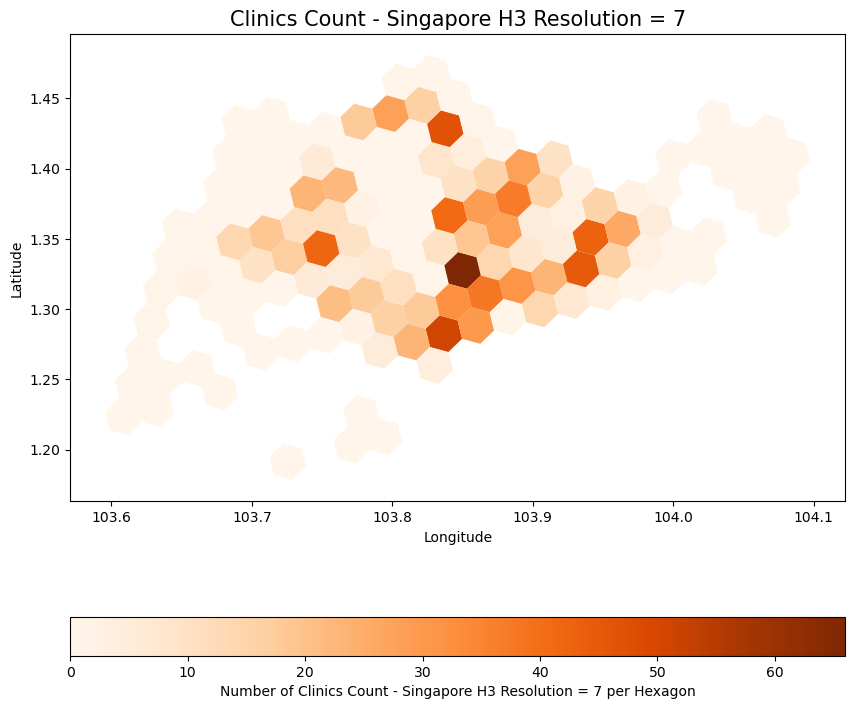

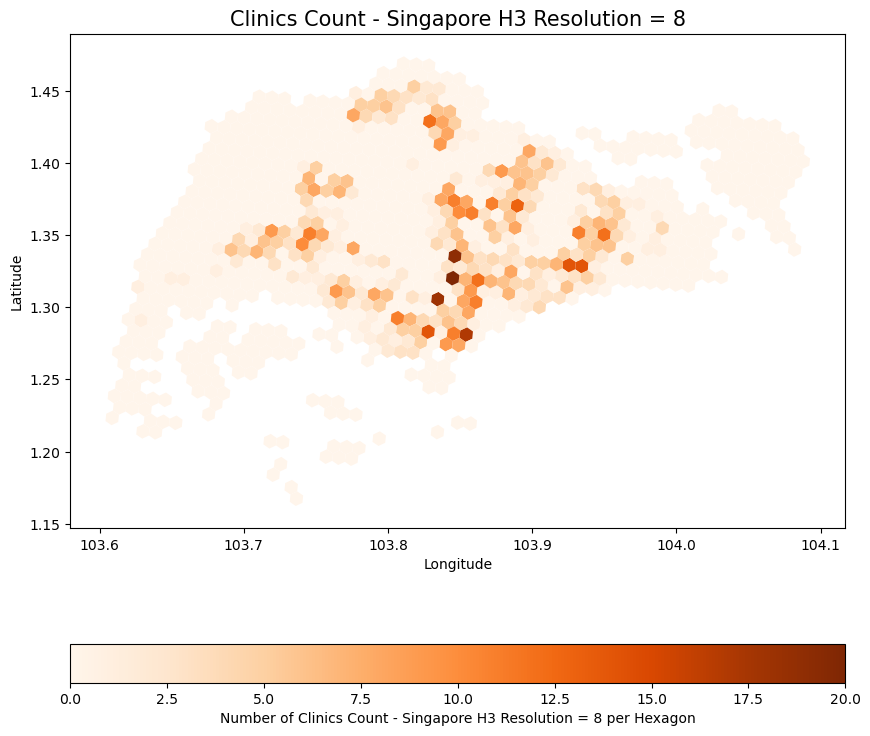

In [18]:
#plot clinics count
plot_hex_map(SingaporeR7, 'clinics_count', 'Clinics Count - Singapore H3 Resolution = 7')
plot_hex_map(SingaporeR8, 'clinics_count', 'Clinics Count - Singapore H3 Resolution = 8')

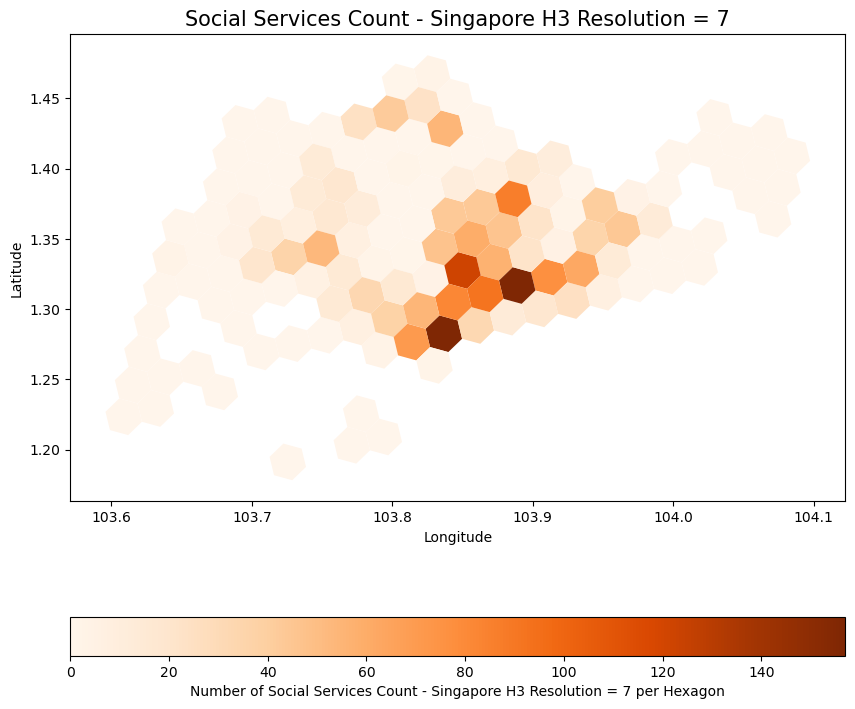

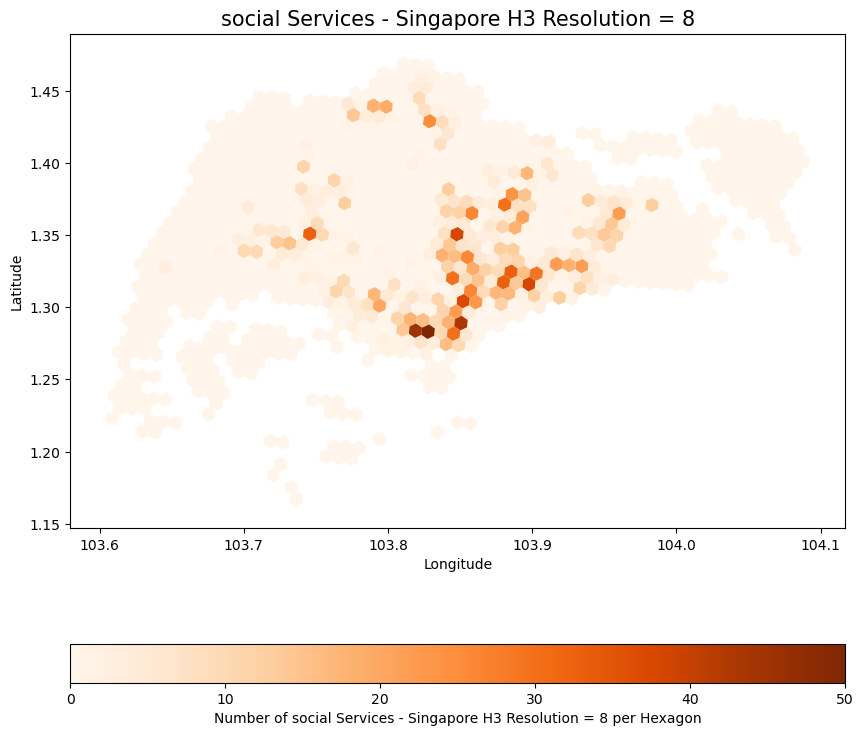

In [19]:
#plot clinics count
plot_hex_map(SingaporeR7, 'socialservices_count', 'Social Services Count - Singapore H3 Resolution = 7')
plot_hex_map(SingaporeR8, 'socialservices_count', 'social Services - Singapore H3 Resolution = 8')

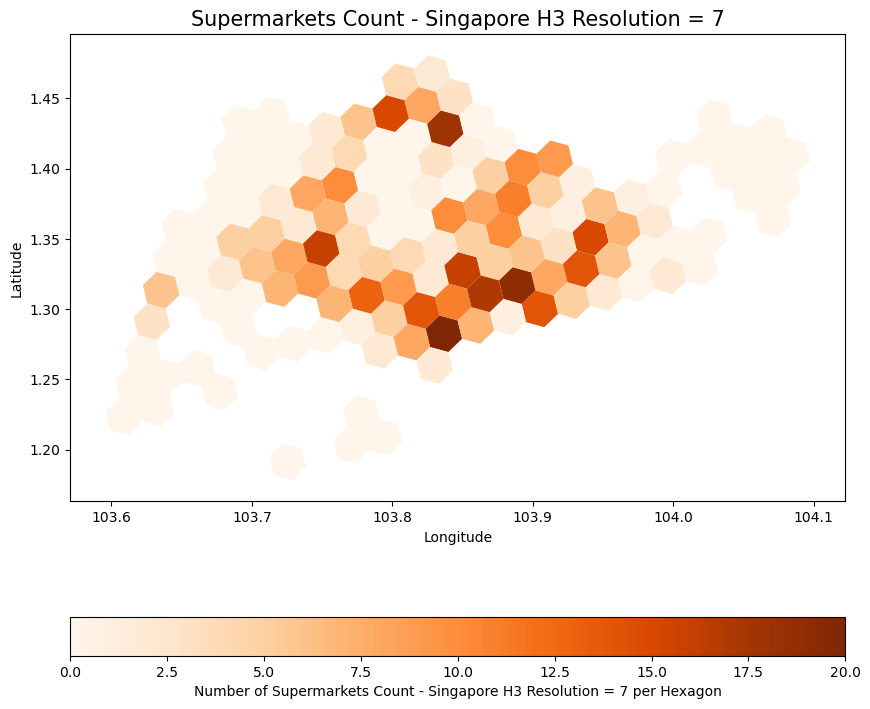

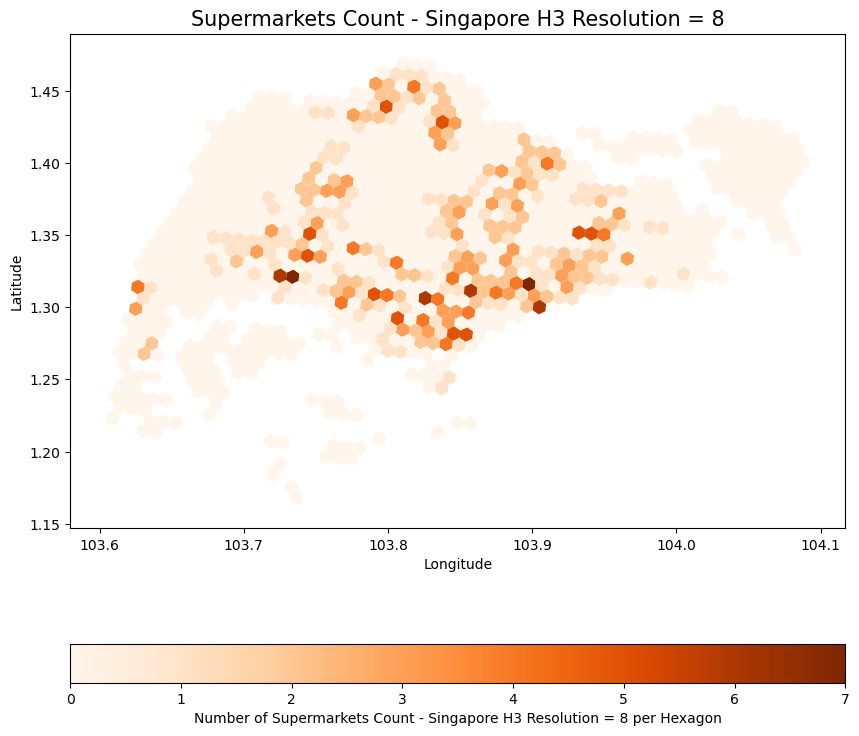

In [20]:
#plot clinics count
plot_hex_map(SingaporeR7, 'supermarkets_count', 'Supermarkets Count - Singapore H3 Resolution = 7')
plot_hex_map(SingaporeR8, 'supermarkets_count', 'Supermarkets Count - Singapore H3 Resolution = 8')

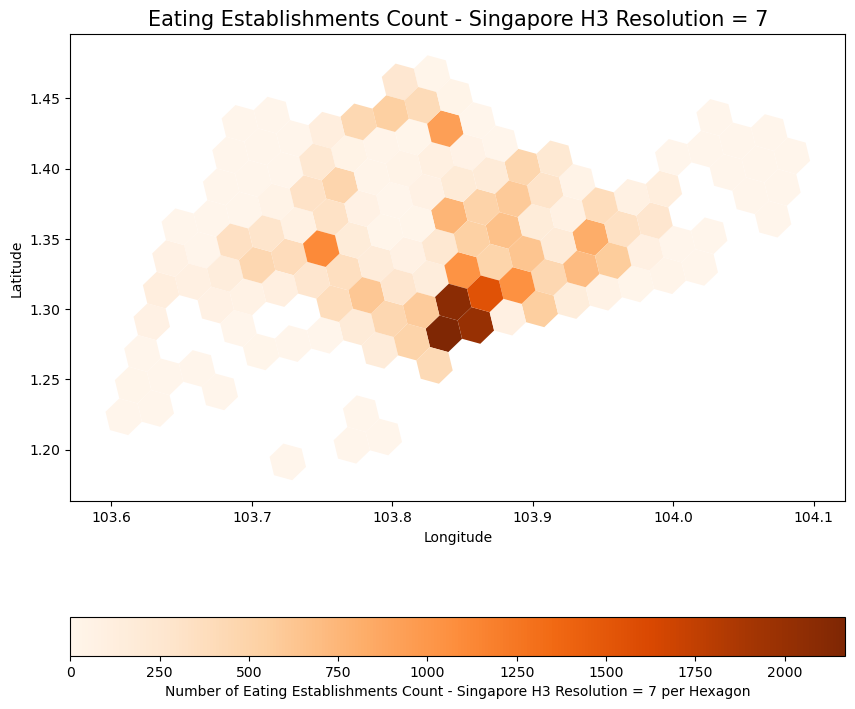

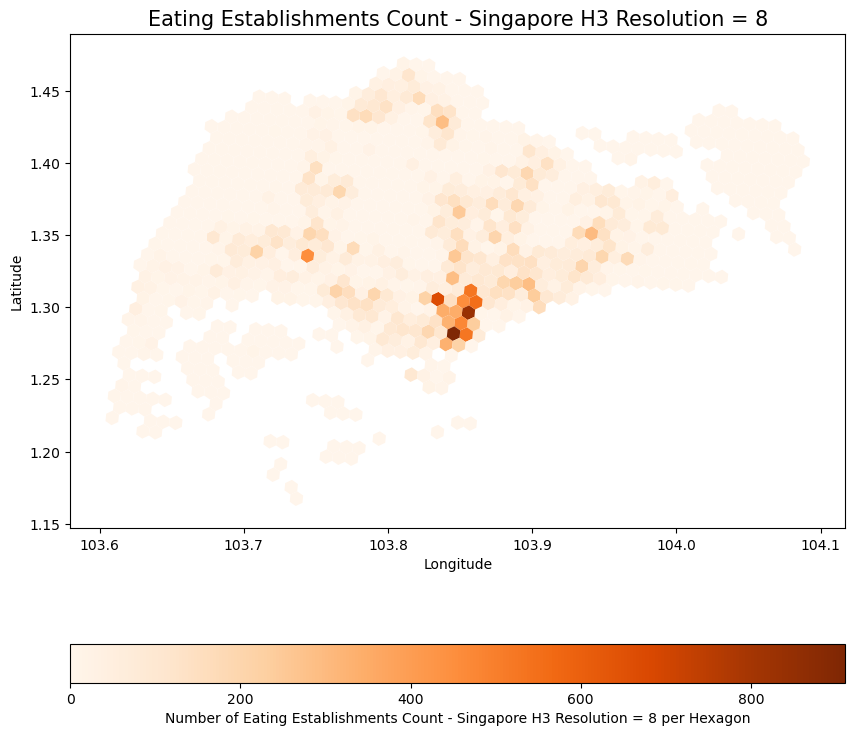

In [21]:
#plot clinics count
plot_hex_map(SingaporeR7, 'eatingestablishments_count', 'Eating Establishments Count - Singapore H3 Resolution = 7')
plot_hex_map(SingaporeR8, 'eatingestablishments_count', 'Eating Establishments Count - Singapore H3 Resolution = 8')

In [22]:
#save updated files
SingaporeR7.to_file("Singapore_H3_R7_updated.gpkg", layer='Singapore_H3_R7', driver="GPKG")
SingaporeR8.to_file("Singapore_H3_R8_updated.gpkg", layer='Singapore_H3_R8', driver="GPKG")